# Harnessing the power of runtime Session: Running iterative algorithm

# Imports

In [1]:
import numpy as np
from qiskit import *
from qiskit.quantum_info import hellinger_fidelity
from qiskit.visualization import plot_distribution

from qiskit_ibm_provider import IBMProvider

# Operators from Qiskit
from qiskit.quantum_info import SparsePauliOp

from qiskit.circuit.library import EfficientSU2, RealAmplitudes

# Import the primitives from Qiskit
from qiskit.primitives import Sampler, Estimator

# Import simulator primtives from Aer
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit_aer.primitives import Estimator as AerEstimator

from scipy.optimize import minimize

# Plotting tools
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Setup: Test circuit

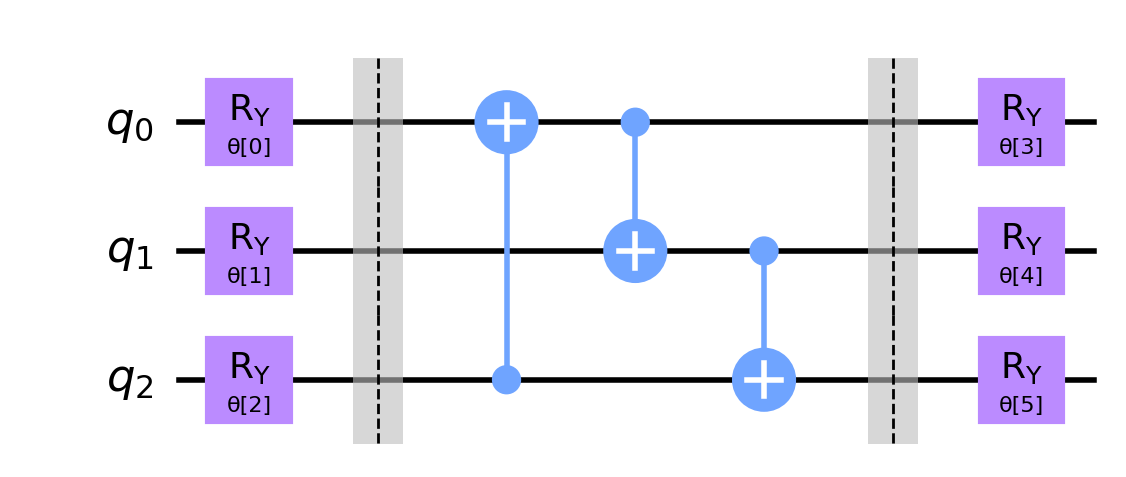

In [2]:
N = 3
ansatz = RealAmplitudes(num_qubits=N, reps=1, entanglement="circular", insert_barriers=True)
qc = ansatz.decompose()
qc.draw('mpl')

# Setup runtime service

In [4]:
service = QiskitRuntimeService(channel="ibm_quantum")

# Cost function

In [5]:
cost_history = []
def cost_func(params, circuit, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    global cost_history
    energy = estimator.run(circuit, hamiltonian, parameter_values=params).result().values[0]
    cost_history.append(energy)
    return energy

# Run inside a Session

In [6]:
# setup a random operator
oper = SparsePauliOp.from_list([
    ("IIZ", 1.0),
    ("XIY", -0.5),
    ("ZYX", 1.0)
])

# create some random initial parameters
num_params = ansatz.num_parameters
np.random.seed(54321)
init_params = 2 * np.pi * np.random.random(num_params)

with Session(backend="ibm_peekskill"):
    options = Options()
    options.execution.shots = 10000
    options.optimziation_level = 3
    options.resilience_level = 1
    estimator = Estimator(options=options)
    res = minimize(cost_func, init_params, args=(qc, oper, estimator), method="COBYLA", options={"maxiter": 30})
    
res

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -0.9237271670470293
       x: [ 5.732e+00  4.916e+00  5.976e+00  2.702e+00  4.443e+00
            3.598e+00]
    nfev: 30
   maxcv: 0.0

# Plotting results

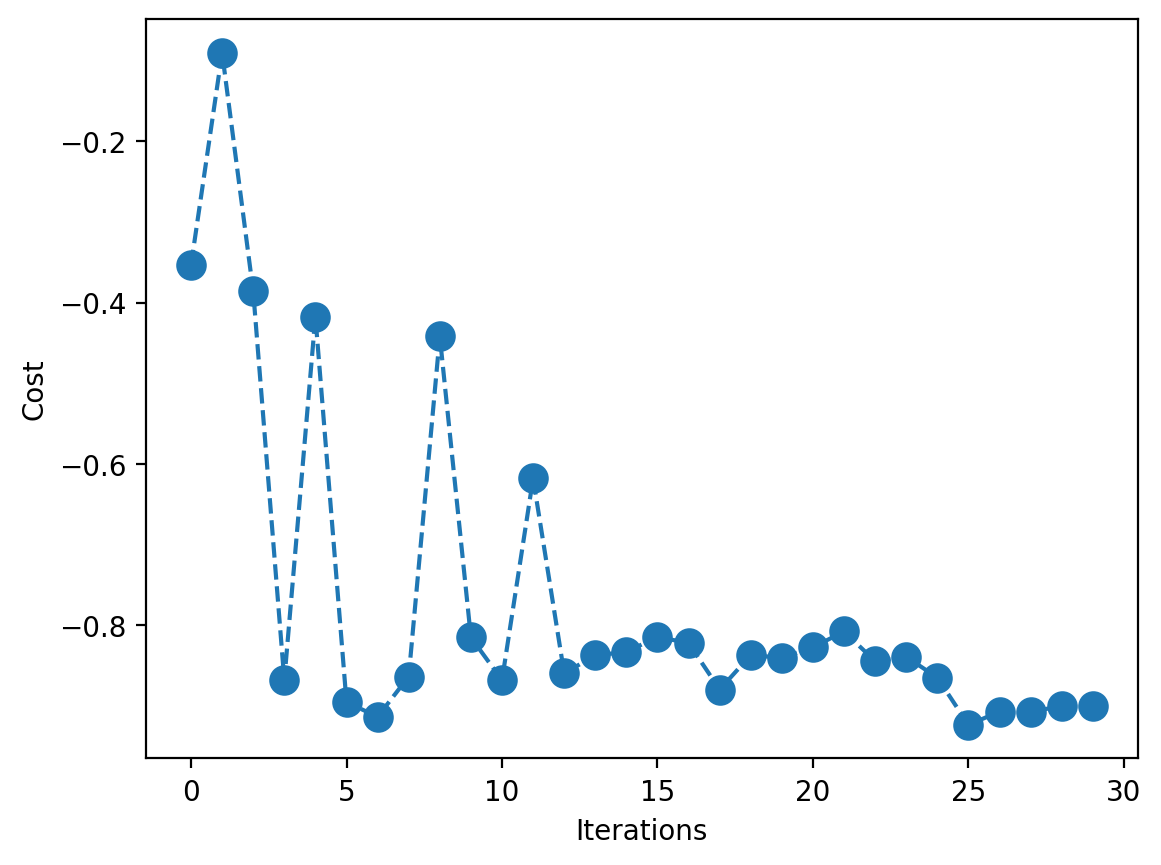

In [8]:
fig, ax = plt.subplots()
ax.plot(range(len(cost_history)), cost_history, "o--", ms=10)
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost");

In [6]:
import numpy
print(f"numpy version {numpy.__version__}")

import qiskit_ibm_runtime
print(f"qiskit runtime version {qiskit_ibm_runtime.version.get_version_info()}")

import qiskit.tools.jupyter
%qiskit_version_table

numpy version 1.23.5
qiskit runtime version 0.13.0
